import Pkg
lst = ["NeuralPDE", "Lux", "ModelingToolkit", "Optimization", "OptimizationOptimJL", "OrdinaryDiffEq", "Plots"]
for s in lst
    Pkg.add(s)
end

In [1]:
using NeuralPDE, Lux, ModelingToolkit, Optimization, OptimizationOptimJL, OrdinaryDiffEq, Plots
import ModelingToolkit: Interval, infimum, supremum
@parameters t ,σ_ ,β, ρ
@variables x(..), y(..), z(..)
Dt = Differential(t)
eqs = [Dt(x(t)) ~ σ_*(y(t) - x(t)),
       Dt(y(t)) ~ x(t)*(ρ - z(t)) - y(t),
       Dt(z(t)) ~ x(t)*y(t) - β*z(t)]

bcs = [x(0) ~ 1.0, y(0) ~ 0.0, z(0) ~ 0.0]
domains = [t ∈ Interval(0.0,1.0)]
dt = 0.01

In [ ]:
using ModelingToolkit

In [ ]:
ε_1 = 5.0
@parameters t ,σ_ ,β, ρ
@variables x(..), y(..), z(..)
Dt = Differential(t)
eqs = [Dt(x(t)) ~ σ_*(y(t) - x(t)),
       Dt(y(t)) ~ x(t)*(ε_1*ρ - z(t)) - y(t),
       Dt(z(t)) ~ x(t)*y(t) - β*z(t)]


3-element Vector{Equation}:
 Differential(t)(x(t)) ~ σ_*(y(t) - x(t))
 Differential(t)(y(t)) ~ (5.0ρ - z(t))*x(t) - y(t)
 Differential(t)(z(t)) ~ x(t)*y(t) - β*z(t)

In [ ]:
input_ = length(domains)
n = 8
chain1 = Lux.Chain(Dense(input_,n,Lux.σ),Dense(n,n,Lux.σ),Dense(n,n,Lux.σ),Dense(n,1))
chain2 = Lux.Chain(Dense(input_,n,Lux.σ),Dense(n,n,Lux.σ),Dense(n,n,Lux.σ),Dense(n,1))
chain3 = Lux.Chain(Dense(input_,n,Lux.σ),Dense(n,n,Lux.σ),Dense(n,n,Lux.σ),Dense(n,1))

Chain(
    layer_1 = Dense(1 => 8, sigmoid_fast),  # 16 parameters
    layer_2 = Dense(8 => 8, sigmoid_fast),  # 72 parameters
    layer_3 = Dense(8 => 8, sigmoid_fast),  # 72 parameters
    layer_4 = Dense(8 => 1),            # 9 parameters
)         # Total: 169 parameters,
          #        plus 0 states, summarysize 64 bytes.

In [ ]:
function lorenz!(du,u,p,t)
    du[1] = 10.0*(u[2]-u[1])
    du[2] = u[1]*(28.0-u[3]) - u[2]
    du[3] = u[1]*u[2] - (8/3)*u[3]
   end
   
   u0 = [1.0;0.0;0.0]
   tspan = (0.0,1.0)
   prob = ODEProblem(lorenz!,u0,tspan)
   sol = solve(prob, Tsit5(), dt=0.1)
   ts = [infimum(d.domain):dt:supremum(d.domain) for d in domains][1]
   function getData(sol)
       data = []
       us = hcat(sol(ts).u...)
       ts_ = hcat(sol(ts).t...)
       return [us,ts_]
   end
   data = getData(sol)
   
   (u_ , t_) = data
   len = length(data[2])

101

u_ это датасет данных

In [ ]:
depvars = [:x,:y,:z]
function additional_loss(phi, θ , p)
    return sum(sum(abs2, phi[i](t_ , θ[depvars[i]]) .- u_[[i], :])/len for i in 1:1:3)
end

additional_loss (generic function with 1 method)

In [ ]:
discretization = NeuralPDE.PhysicsInformedNN([chain1 , chain2, chain3],NeuralPDE.GridTraining(dt), param_estim=true, additional_loss=additional_loss)
@named pde_system = PDESystem(eqs,bcs,domains,[t],[x(t), y(t), z(t)],[σ_, ρ, β], defaults=Dict([p .=> 1.0 for p in [σ_, ρ, β]]))
prob = NeuralPDE.discretize(pde_system,discretization)
callback = function (p,l)
    println("Current loss is: $l")
    return false
end

#p_ = res.u[end-2:end] # 
#p_ = [9.93, 28.002, 2.667]

#7 (generic function with 1 method)

In [ ]:
res = Optimization.solve(prob, BFGS(); callback = callback, maxiters=5000)

In [ ]:
p_ = res.u[end-2:end]

3-element Vector{Float64}:
  9.995369034901838
 28.008104903768732
  2.664178020622884

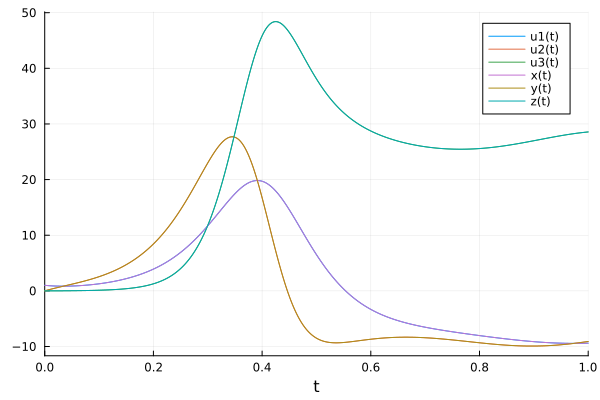

In [ ]:
minimizers = [res.u.depvar[depvars[i]] for i in 1:3]
ts = [infimum(d.domain):dt/10:supremum(d.domain) for d in domains][1]
u_predict  = [[discretization.phi[i]([t],minimizers[i])[1] for t in ts] for i in 1:3]
plot(sol)
plot!(ts, u_predict, label = ["x(t)" "y(t)" "z(t)"])